# Predicting Stock Market Movement by building a Neural Network with Newspaper Headlines

TO DO LIST:
    Iterate through Guardian and NYT and store it in NoSQL
    Get FT API working
    Looking into Wayback Machine 
    

## Introduction

Will be using CRoss-Industry Standard Process for Data Mining (CRISP-DM) as the outline for the project 

## Importing Libraries 

In [1]:
import pandas as pd
import tradingeconomics as te
import json
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil
from datetime import datetime
import requests
from pandas_datareader import data as dr
import pandas_datareader

## Business Understanding

## Collecting the needed Data

### FTSE Data

#### Pandas Data Reader

To get us started, we can easily extract Open and Close prices for the FTSE every day in the range we want by using the helpful Pandas Data Reader tool, which reads data for us off of various website. We just have to specify which type of data we want, and in what range of dates.

In [2]:
# dont run this again!!
start_date = '2010-01-01'
end_date = '2020-01-01'
data = pandas_datareader.stooq.StooqDailyReader(symbols='^UKX', start=start_date, end=end_date).read()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2526 entries, 2019-12-31 to 2010-01-04
Data columns (total 5 columns):
Open      2526 non-null float64
High      2526 non-null float64
Low       2526 non-null float64
Close     2526 non-null float64
Volume    2524 non-null float64
dtypes: float64(5)
memory usage: 118.4 KB


Personally, I would prefer to have the data in chronological order, starting from 2010, so I will reverse the index to reorder the dataframe

In [4]:
data = data.reindex(index=data.index[::-1])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2526 entries, 2010-01-04 to 2019-12-31
Data columns (total 5 columns):
Open      2526 non-null float64
High      2526 non-null float64
Low       2526 non-null float64
Close     2526 non-null float64
Volume    2524 non-null float64
dtypes: float64(5)
memory usage: 118.4 KB


Great! Now it's in the right order, I can delete columns of data that I see fit. For now, I'll keep it all, but I am not expecting to use daily Highs/Lows or Volume in my analysis, so might delete those columns later.

In [6]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,5412.88,5500.34,5410.82,5500.34,7.392485e+08
2010-01-05,5500.34,5536.38,5480.71,5522.50,1.073713e+09
2010-01-06,5522.50,5536.48,5497.65,5530.04,9.274415e+08
2010-01-07,5530.04,5551.66,5499.80,5526.72,1.109908e+09
2010-01-08,5526.72,5549.25,5494.79,5534.24,9.713993e+08


It is worth noting at this point that these are Adjusted prices. There are a few different ways of valuing a stock, and therefore the way we value the stocks tracked in this Index will determine the price given for the Index as a whole. Adjusted values are more accurate - they take into account "dividends, stock splits and new stock offerings to determine a value". 

#### CSV files from Online

Getting intraday data proved more difficult - I wanted the prices of the FTSE 5 minutes after opening, and at a few points throughout the day. To do this, I found a historical dataframe online that quoted the prices of the FTSE every 5 minutes. A large file, as you can imagine. Using it, all I have to do it parse through the document, extracting the prices that I want at the particular times, being careful to note that the times are a little tricky to get right, as this dataset it not only on Chicago time, but also doesn't do a great job of noting daylight savings times. First, let's have a closer look at this dataset

In [7]:
intraday_data = pd.read_csv('ftse_data/ftse100-5m.csv')

In [8]:
intraday_data.head()

,Date;Open;High;Low;Close;Adj Close;Volume
0,10/12/1999;02:00:00;6722;6735;6722;6735;0
1,10/12/1999;02:05:00;6734;6751;6734;6747;0
2,10/12/1999;02:10:00;6745;6747;6742;6742;0
3,10/12/1999;02:15:00;6750;6760;6750;6760;0
4,10/12/1999;02:20:00;6764;6764;6755;6755;0


In [9]:
df1 = intraday_data['Date;Open;High;Low;Close;Adj Close;Volume'].str.split(";",expand=True,)
df1.columns=['Date','Open','High','Low','Close','Adj Close','Volume']
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/12/1999,02:00:00,6722,6735,6722,6735,0
1,10/12/1999,02:05:00,6734,6751,6734,6747,0
2,10/12/1999,02:10:00,6745,6747,6742,6742,0
3,10/12/1999,02:15:00,6750,6760,6750,6760,0
4,10/12/1999,02:20:00,6764,6764,6755,6755,0


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854331 entries, 0 to 854330
Data columns (total 7 columns):
Date         854331 non-null object
Open         854331 non-null object
High         854331 non-null object
Low          854331 non-null object
Close        854331 non-null object
Adj Close    854331 non-null object
Volume       854331 non-null object
dtypes: object(7)
memory usage: 45.6+ MB


In [11]:
df1.iloc[327380:327385]

,Date,Open,High,Low,Close,Adj Close,Volume
327380,31/12/2009,05:55:00,5365,5368,5364.5,5367,265
327381,04/01/2010,02:00:00,5369,5392,5365,5390,4177
327382,04/01/2010,02:05:00,5390,5398.5,5389.5,5398.5,974
327383,04/01/2010,02:10:00,5397.5,5409.5,5396.5,5408.5,1699
327384,04/01/2010,02:15:00,5409,5412,5398.5,5399.5,1478


So, the data we are looking for only starts on row 327380

In [12]:
df2 = df1.Date.str.split("/",expand=True,)
df2.columns=['Day','Month','Year']
df2.head()

,Day,Month,Year
0,10,12,1999
1,10,12,1999
2,10,12,1999
3,10,12,1999
4,10,12,1999


In [13]:
df = pd.concat([df2,df1],axis=1)

In [14]:
df.head()

,Day,Month,Year,Date,Open,High,Low,Close,Adj Close,Volume
0,10,12,1999,10/12/1999,02:00:00,6722,6735,6722,6735,0
1,10,12,1999,10/12/1999,02:05:00,6734,6751,6734,6747,0
2,10,12,1999,10/12/1999,02:10:00,6745,6747,6742,6742,0
3,10,12,1999,10/12/1999,02:15:00,6750,6760,6750,6760,0
4,10,12,1999,10/12/1999,02:20:00,6764,6764,6755,6755,0


So, now we have our dataframe in a format that is easier to use

Unfortunately, there may be a problem which needs looking into...

In [15]:
now = df.loc[(df['Year'] == '2010')  & (df['Month'] == '01')] 
now.head()
now = now.reset_index()

In [16]:
now['Adj Close'] = now['Adj Close'].astype(float)
now['Close'] = now['Close'].astype(float)
now['Day'] = now['Day'].astype(float)
now['Month'] = now['Month'].astype(float)
now['Year'] = now['Year'].astype(float)

In [17]:
close_adj_prices = []
close_prices = []

for x in range(0,len(now)):
    if(now['Open'][x] == '10:55:00'):
        close_adj_prices.append(now['Adj Close'][x])
        close_prices.append(now['Close'][x])

In [18]:
print(data[0:20].Close.values)

[5500.34 5522.5  5530.04 5526.72 5534.24 5538.07 5498.71 5473.48 5498.2
 5455.37 5494.39 5513.14 5420.8  5335.1  5302.99 5260.31 5276.85 5217.47
 5145.74 5188.52]


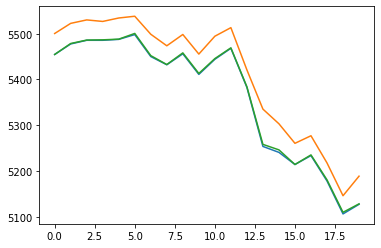

In [19]:
plt.plot(close_prices)
plt.plot(data[0:20].Close.values)
plt.plot(close_adj_prices)

We have a problem here - the two menthods of valuation of the FTSE are clearly differing...need to sort.

"Problem Solved" - The difference here is because the Pandas Data Reader results are the values of the FTSE Index, whereas the values from our online database are the price of the futures on the FTSE. There is a slight discrepancy of price. As long as we keep everything on the same scale, the problem should be solved. So we'll derive all our prices from the database, unless we find an intraday FTSE valuation out of Pandas Data Reader. 

#### Visualisations and filtering that might be useful later

In [20]:
# values = pd.DataFrame(columns=['time','num_of_values'])
# count=1
# for y in range(2000,2020):
#     for x in range(1,13):
#         z = len(df.loc[(df['Year'] == y)  & (df['Month'] == x)])
#         values.loc[count]=[int(count),int(z)]
#         count += 1

# values.time = values.time.astype('int32')
# values.num_of_values = values.num_of_values.astype('int32')

# sns.set()
# ax = sns.lineplot(y="num_of_values", x="time", data=values)

So a basic plot of our data shows that for more recent years, we have many more data points.

In [21]:
# values2 = pd.DataFrame(columns=['time','num_of_days_counted'])
# count=1
# for y in range(2000,2020):
#     for x in range(1,13):
#         z = df.loc[(df['Year'] == y) & (df['Month'] == x)]
#         days_counted = len(z.Day.unique())
#         values2.loc[count]=[int(count),int(days_counted)]
#         count += 1

# values2.time = values2.time.astype('int32')
# values2.num_of_days_counted = values2.num_of_days_counted.astype('int32')

# sns.set()
# ax = sns.lineplot(y="num_of_days_counted", x="time", data=values2)

The maximum number of days the market can be open in a month is 23, so we have plenty data on price movements outside of the traditional open hours too! We could use this data to explore price changes on after-hours trading, but for now, let's just extract the data we originally wanted. 

Plan for now:

Get list of working days from 2010 to 2019

Data is on Chicago time, shift all data 6 hours head to GMT

Shift data to GMT+1 according to daylight savings times 

Filter through all data to get times and days data you want and save in a new df 

In [22]:
# from dateutil.rrule import *
# def daterange(start_date, end_date):
#     return list(rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR)))

In [23]:
# # some are kindly provided by gov.uk, but there are some missing which I will add in below 
# from govuk_bank_holidays.bank_holidays import BankHolidays
# bank_holidays = BankHolidays()
# count = 0
# for bank_holiday in bank_holidays.get_holidays():
#     if (count<30):
#         print(bank_holiday['date'])
#         count += 1

In [24]:
# bank_holidays = ['2010-01-01','2010-04-02','2010-04-05','2010-05-03','2010-05-31','2010-08-30','2010-12-27','2010-12-28', \
#                  '2011-01-03','2011-04-22','2011-04-25','2011-05-02','2011-05-30','2011-08-29','2011-12-26','2011-12-27', \
#                  '2012-01-02','2012-04-06','2012-04-09','2012-05-07','2012-06-04','2012-06-05','2012-08-27','2012-12-25','2012-12-26', \
#                  '2013-01-01','2013-03-29','2013-04-01','2013-05-06','2013-05-27','2013-08-26','2013-12-25','2013-12-26', \
#                  '2014-01-01','2014-04-18','2014-04-21','2014-05-06','2014-05-26','2014-08-25','2014-12-25','2014-12-26', \
#                  '2015-01-01','2015-04-03','2015-04-06','2015-05-04','2015-05-25','2015-08-31','2015-12-25','2015-12-28', \
#                  '2016-01-01','2016-03-25','2016-03-28','2016-05-02','2016-05-30','2015-08-31','2016-12-26','2016-12-27', \
#                  '2017-01-02','2017-04-14','2017-04-17','2017-05-01','2017-05-29','2015-08-31','2017-12-25','2017-12-26', \
#                  '2018-01-01','2018-03-30','2018-04-02','2018-05-07','2018-05-28','2015-08-31','2018-12-25','2018-12-26', \
#                  '2019-01-01','2019-04-19','2019-04-22','2019-05-06','2019-05-27','2015-08-31','2019-12-25','2019-12-26']

In [25]:
# start_date = datetime(2010, 1, 1)
# end_date = datetime(2019, 12, 31)
# working_days = daterange(start_date,end_date)

In [26]:
# open_days = []
# for x in range(len(working_days)):
#     year = working_days[x].strftime("%Y")
#     month = working_days[x].strftime("%m")
#     day = working_days[x].strftime("%d")
#     date = year + "-" + month + "-" + day
#     if date not in bank_holidays:
#         open_days.append(date)

So, open days is a list that the London Stock exchange is open for trading! Now to create a dataframe with these dates as the rows, and the FTSE values at various times!

In [27]:
# FTSE_data = pd.DataFrame(open_days,columns=["Date"])
# FTSE_data.head()

In [28]:
# df2 = FTSE_data.Date.str.split("-",expand=True,)
# df2.columns=['Year','Month','Day']
# df2.head()

In [29]:
# FTSE_data = pd.concat([FTSE_data,df2], axis=1)
# FTSE_data.head()

In [30]:
# FTSE_data["5_minutes_after_opening"] = np.nan
# FTSE_data["1_hour_after_opening"] = np.nan
# FTSE_data["2_hours_after_opening"] = np.nan
# FTSE_data["4_hours_after_opening"] = np.nan
# FTSE_data["Closing"] = np.nan
# FTSE_data['Year'] = FTSE_data['Year'].astype(int)
# FTSE_data['Month'] = FTSE_data['Month'].astype(int)
# FTSE_data['Day'] = FTSE_data['Day'].astype(int)
# FTSE_data.head()

In [31]:
# FTSE_data.tail()

In [32]:
# df.head()

In [33]:
# for x in range(0,len(FTSE_data)):
    
#     year = FTSE_data['Year'][x]
#     month = FTSE_data['Month'][x]
#     day = FTSE_data['Day'][x]
    
#     if(year == 2010):
#         if((month == 3)|(month == 11)):
#             if(month == 3):
#                 if((day>14) & (day<28)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 11):
#                 if(day>0 & day<8):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
#                     if((day == 3) | (day == 5)):
#                         price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:05:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']
    
#     if(year == 2011):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>13) & (day<27)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day > 30):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<7):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
    
#     if(year == 2012):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>11) & (day<25)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day > 28):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<5):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
    
#     if(year == 2013):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>10) & (day<24)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day > 27):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<4):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
    
#     if(year == 2014):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>9) & (day<23)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day > 26):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<3):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
    
#     if(year == 2015):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>8) & (day<22)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day >25):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<2):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
                
#     if(year == 2016):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>13) & (day<27)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day >30):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<7):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
    
#     if(year == 2017):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>12) & (day<26)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day >29):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<6):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
         
#     if(year == 2018):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>11) & (day<25)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day > 28):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<5):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
    
#     if(year == 2019):
#         if((month == 3)|(month == 11)|(month== 10)):
#             if(month == 3):
#                 if((day>10) & (day<24)):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '03:00:00')]['Close']
#             if(month == 10):
#                 if(day >27):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']   
#             if(month == 11):
#                 if(day>0 & day<4):
#                     price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '01:00:00')]['Close']
                    
#         else:
#             price = df.loc[(df['Year'] == year) & (df['Month'] == month) & (df['Day'] == day) & (df['Open'] == '02:00:00')]['Close']  
     
#     try:
#         FTSE_data.at[x,'5_minutes_after_opening'] = float(price.values[0])
#     except:
#         FTSE_data.at[x,'5_minutes_after_opening'] = 0

In [34]:
# FTSE_data.head()

In [35]:
# FTSE_data['5_minutes_after_opening'].value_counts()

#### Financial APIs that might be useful later

Using Quandl, a financial data API. 
API key = cPznWn5h_Ek547FYcuUT

Using Trading Economics, no key yet

In [36]:
# te.login()

In [37]:
# te.getMarketsSearch(country='united kingdom', category = 'index')[0]['DailyChange']

In [38]:
# now = te.getMarketsIntraday(symbols='UKX:IND',initDate='2015-01-01', endDate='2015-01-01')

In [39]:
# now

In [40]:
# te.fetchMarkets(symbol='UKX:IND', initDate='2017-01-01', endDate='2017-06-15')

In [41]:
# te.getMarketsData(marketsField='index', output_type='df')

In [42]:
# te.getHistorical('UKX:IND')

In [43]:
# ftse = pd.read_csv('ftse_data/ftse2018.csv')

In [44]:
# ftse.tail()

In [45]:
# msft = yf.Ticker("MSFT")
# msft.info

In [46]:
# data = yf.download("^FTSE", start="2020-05-01", end="2020-05-02", interval='5m')

In [47]:
# len(data)

In [48]:
# data.tail()

### Newspaper Data

Obvious APIs to pursue - Guardian, FT and NYT. Will need more than this though!

#### Guardian (UK)

In [49]:
credentials = 'c853c290-3354-45c1-aa01-ac9bb7bf8ab7'  
r = requests.get('https://content.guardianapis.com/search?from-date=2020-05-22&to-date=2020-05-22&production-office=uk&section=business&&api-key=' + credentials)

In [50]:
r

<Response [200]>

In [51]:
r.text

'{"response":{"status":"ok","userTier":"developer","total":11,"startIndex":1,"pageSize":10,"currentPage":1,"pages":2,"orderBy":"newest","results":[{"id":"sport/2020/may/22/mclaren-pledges-luxury-cars-as-collateral-in-bid-to-secure-250m","type":"article","sectionId":"business","sectionName":"Business","webPublicationDate":"2020-05-22T17:50:26Z","webTitle":"McLaren pledges luxury cars as collateral in bid to secure Â£250m","webUrl":"https://www.theguardian.com/sport/2020/may/22/mclaren-pledges-luxury-cars-as-collateral-in-bid-to-secure-250m","apiUrl":"https://content.guardianapis.com/sport/2020/may/22/mclaren-pledges-luxury-cars-as-collateral-in-bid-to-secure-250m","isHosted":false,"pillarId":"pillar/news","pillarName":"News"},{"id":"business/2020/may/22/uk-holiday-firm-slg-collapses-with-2500-job-losses","type":"article","sectionId":"business","sectionName":"Business","webPublicationDate":"2020-05-22T17:36:23Z","webTitle":"Shearings coach travel owner SLG collapses with 2,500 job losses

In [52]:
def guardian_headline_finder(r):
    #takes in r, the API response, and evaluates the text, returning a list of the headlines contained
    cleaner_headlines_list = []
    clean_headlines_list = []
    results = r.text.split("results")
    messy_headlines = results[1].split("webTitle")
    messy_headlines.pop(0)
    messy_headlines
    for x in messy_headlines:
        cleaner_headlines = x.split("webUrl")
        cleaner_headlines_list.append(cleaner_headlines[0])

    for x in cleaner_headlines_list:
        cleaner_headlines2 = x.split(":")
        cleaner_headlines2[1] = cleaner_headlines2[1][1:] #removes first character from the second string
        clean_headlines_list.append(cleaner_headlines2[1][:-3]) #removes final three characters from the second string
    
    return clean_headlines_list

In [53]:
guardian_headline_finder(r)

['McLaren pledges luxury cars as collateral in bid to secure Â£250m',
 'Shearings coach travel owner SLG collapses with 2,500 job losses',
 "Brewers Carlsberg UK and Marston's announce merger",
 'Global markets fall as China moves to tighten control over Hong Kong',
 'UK government borrowing hits record high in April and retail sales slump - as it happened',
 'Ikea to reopen 19 stores during UK lockdown',
 'Burberry cancels dividend after sales plunge 27%',
 'The Covid-19 bill means the Treasury must live with high borrowing',
 'JD Wetherspoon pubs to reopen with staff in goggles post-lockdown',
 'EasyJet founder Stelios fails in attempt to oust chairman and CEO']

Iterate through a few different sections, and also remember to add in the times so you can use them in your analysis 

#### NYT (USA)

In [54]:
credentials = 'AjoGztA9jXOIMfD959PCDLGMb0Ubzwdq'
r2 = requests.get("https://api.nytimes.com/svc/mostpopular/v2/viewed/1.json?api-key=" + credentials)

In [55]:
r2

<Response [200]>

In [66]:
r2.text

'{"status":"OK","copyright":"Copyright (c) 2020 The New York Times Company.  All Rights Reserved.","num_results":20,"results":[{"uri":"nyt://article/120696c7-aa80-5be0-b7da-0649b449c913","url":"https://www.nytimes.com/2020/05/26/nyregion/amy-cooper-dog-central-park.html","id":100000007156920,"asset_id":100000007156920,"source":"New York Times","published_date":"2020-05-26","updated":"2020-05-27 09:30:30","section":"New York","subsection":"","nytdsection":"new york","adx_keywords":"Black People;Race and Ethnicity;Social Media;Discrimination;Dogs;Birdwatching;Cooper, Amy (May 25, 2020 Central Park Incident);Central Park (Manhattan, NY)","column":null,"byline":"By Sarah Maslin Nir","type":"Article","title":"White Woman Is Fired After Calling Police on Black Man in Central Park","abstract":"Video of the incident touched off intense discussions about the history of black people being falsely reported to the police.","des_facet":["Black People","Race and Ethnicity","Social Media","Discrimina

In [131]:
def nyt_headline_finder(r):
    #takes in r, the API response, and evaluates the text, returning a list of the headlines contained
    dirty_headlines_list = []
    cleaner_headlines_list = []
    clean_headlines_list = []
    results = r.text.split("results")
    
    messy_headlines = results[2].split("title")
    messy_headlines.pop(0)
    messy_headlines
    for x in messy_headlines:
        dirty_headlines = x.split("title")
        dirty_headlines_list.append(dirty_headlines[0])

    for x in dirty_headlines_list:
        dirty_headlines2 = x.split(":")
        dirty_headlines2[1] = dirty_headlines2[1][1:]#removes first character from the second string
        cleaner_headlines_list.append(dirty_headlines2[1]) #removes final three characters from the second string
    
    for x in cleaner_headlines_list:
        if x[-9:-1] == 'abstract':
            clean_headlines_list.append(x[:-12])
        else:
            clean_headlines_list.append(x)
            
    return clean_headlines_list

In [120]:
a ='White Woman Is Fired After Calling Police on Black Man in Central Park","abstract"'

In [121]:
a[-9:-1]

'abstract'

In [132]:
nyt_headline_finder(r2)

['White Woman Is Fired After Calling Police on Black Man in Central Park',
 '‘I Can’t Breathe’',
 'Twitter Must Cleanse the Trump Stain',
 'Trump Pushes a Conspiracy Theory That Falsely Accuses a TV Host of Murder',
 'Twitter Refutes Inaccuracies in Trump’s Tweets About Mail-In Voting',
 'A Boy, a Bear and a Close Call in the Mountains of Italy',
 'A Virus-Hunter Falls Prey to a Virus He Underestimated',
 'The Coronavirus Is Deadliest Where Democrats Live',
 'C.D.C. Warns of ‘Aggressive’ Rats Searching for Food During Shutdowns',
 'The Price of a Virus Lockdown',
 'Emergency Child Hunger Program Is Far Behind on Rollout',
 'He Thought He Was Getting Football Physicals. He Was Being Abused.',
 'Joe Rogan Is the New Mainstream Media',
 'We’re Reopening Notre Dame. It’s Worth the Risk.',
 'It’s Not Obesity. It’s Slavery.',
 'After Crowding at Lake of the Ozarks, Missouri Officials Urge Quarantine',
 '2 Weeks, 6.5 Million Coronavirus Tests as Wuhan Nears Goal',
 'Bystander Videos of George

#### Financial Times (UK)

Waiting to get back API from applicaton - chase up email sent on 27th as to why I haven't received the API Key they promised 

### Other Publications/APIs

#### Wayback Machine

## Data Understanding

## Data Preparation

## Modelling

## Evaluation

## Deployment/Iteration 2

## Conclusions